In [1]:
import numpy as np
np.random.seed(42)
np.set_printoptions(suppress=True)
from scipy.optimize import least_squares, curve_fit
from matplotlib import pylab as plt
import pandas as pd
import glob
import time
from tqdm.notebook import tqdm
import os
import random

import warnings
from scipy.optimize import OptimizeWarning
warnings.simplefilter("error", OptimizeWarning)

import seaborn as sns
sns.set()

In [2]:
def plot_allbands_df(df,title=None,ax=plt):
    ugrizYcolors = ["violet","green","red","darkred","grey","black"]
    for i,band in enumerate("ugrizY"):
        subdf = df[df["band"]==band].reset_index(drop=True)
        x = subdf["mjd"]
        y = subdf["flux"]
        yerr = subdf["fluxerr"]
#         ax.errorbar(x,y,yerr=yerr,ls = "None",color=ugrizYcolors[i])
        ax.scatter(x,y,s=5,label=band,color=ugrizYcolors[i])
        if title is not None:
            if ax is not plt:
                ax.set_title(title)
            else:
                ax.title(title)
    return ax

In [3]:
def center_bigdf(df):
    '''
    If either of the following is true:
        - More than 3 observations in a span of 5 consecutive days have a ratio >=2
        - detected_bool = 1
    then the light curve is cropped to a length of 200 days roughly centred about the point when either of the above happens.
    
    When neither of the above 2 criteria are fulfilled, the first 200 days are considered by default

    '''
    
    # Start mjd from 0
    df["mjd"] = df["mjd"] - df["mjd"][0]
    df["ratio"] = abs(df["flux"]/df["fluxerr"])

    df["ratio2bool"] = 0

    subdf_detected = df[df["detected_bool"]==1]
    subdf_ratio2 = df[df["ratio"]>=2]

    # Find the mjd where more than 3 observations in a span of 5 consecutive days have a flux-fluxerr ratio >=2
    smalldf = subdf_ratio2.loc[abs(subdf_ratio2.mjd.diff(periods=-1))<=5]
    for i in range(3):
        smalldf = smalldf[abs(smalldf.mjd.diff(periods=-1))<=5]

    
    if len(subdf_detected)>0 and len(smalldf)>0:
        detected_bool_minmjd = subdf_detected.mjd.values[0]
        custom_bool_minmjd = smalldf.mjd.values[0]

        diffmjd = abs(detected_bool_minmjd - custom_bool_minmjd)/2

        minmjdstart = min(detected_bool_minmjd, custom_bool_minmjd)
        maxmjdstart = max(detected_bool_minmjd, custom_bool_minmjd)

        mjdlim_lower = minmjdstart - (100-diffmjd)
        mjdlim_upper = maxmjdstart + (100-diffmjd)

    elif len(subdf_detected)>0:
        detected_bool_minmjd = subdf_detected.mjd.values[0]
        mjdlim_lower = detected_bool_minmjd - 100
        mjdlim_upper = detected_bool_minmjd + 100

    elif len(smalldf)>0:
        custom_bool_minmjd = smalldf.mjd.values[0]
        mjdlim_lower = custom_bool_minmjd - 100
        mjdlim_upper = custom_bool_minmjd + 100

    else:
        mjdlim_lower = 0
        mjdlim_upper = 200
    
    # Lower limit can't be -ve
    if mjdlim_lower<0:
        mjdlim_upper = mjdlim_upper + abs(mjdlim_lower)
        assert (mjdlim_upper == 200)
        mjdlim_lower = 0

    assert (mjdlim_upper-mjdlim_lower)==200
    
    df.loc[(df["mjd"] >= mjdlim_lower) & (df["mjd"] <= mjdlim_upper),"ratio2bool"] = 1
    
    newdf = df[df["ratio2bool"]==1].reset_index(drop=True)
    
    if len(newdf) == 0:
        mjdlim_upper = 200
        mjdlim_lower = 0
        df.loc[(df["mjd"] >= mjdlim_lower) & (df["mjd"] <= mjdlim_upper),"ratio2bool"] = 1
        newdf = df[df["ratio2bool"]==1].reset_index(drop=True)
    
    return newdf

In [6]:
filels = glob.glob("csv_data/*.csv")

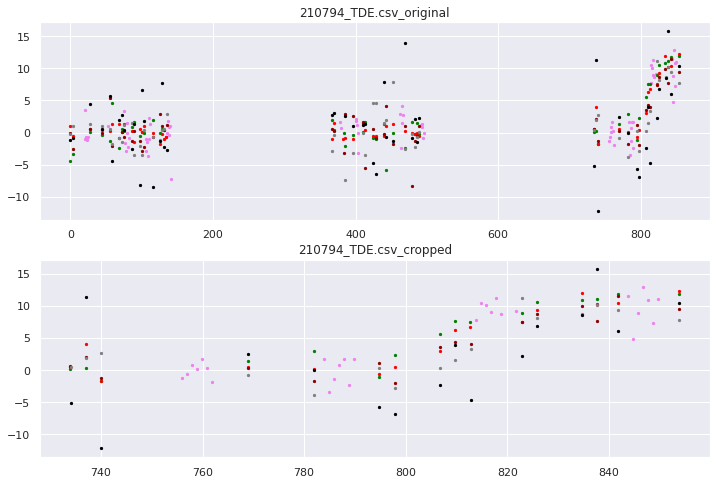

----------------------------------------------------------------------------------------------------


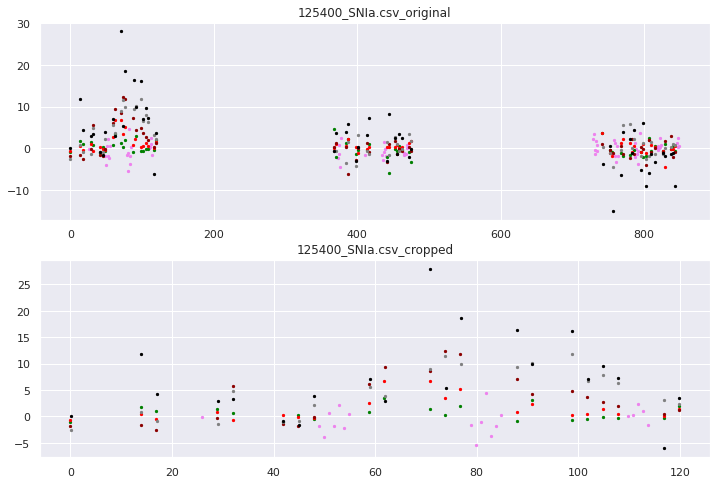

----------------------------------------------------------------------------------------------------


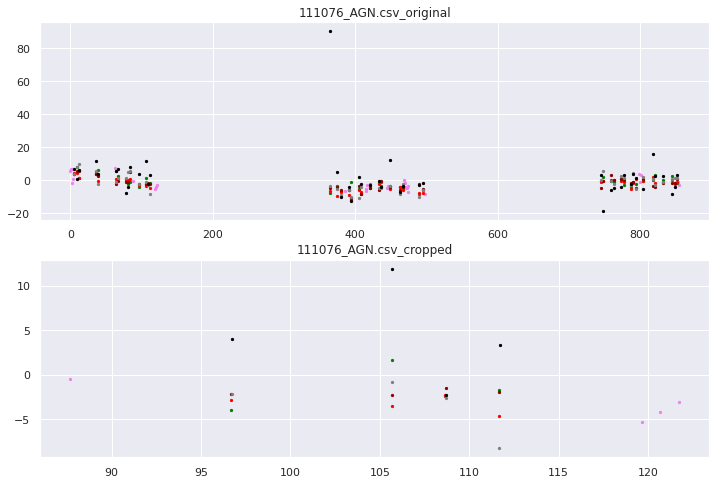

----------------------------------------------------------------------------------------------------


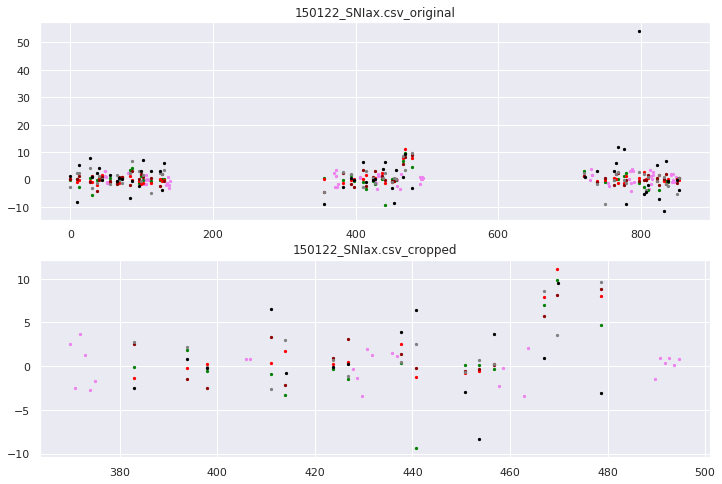

----------------------------------------------------------------------------------------------------


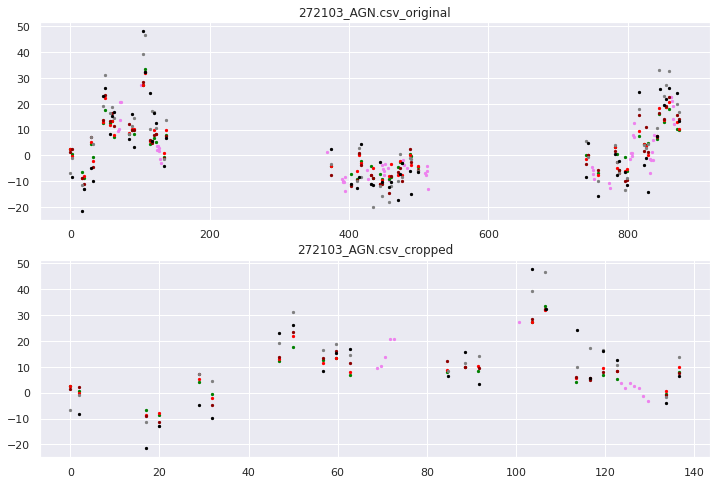

----------------------------------------------------------------------------------------------------


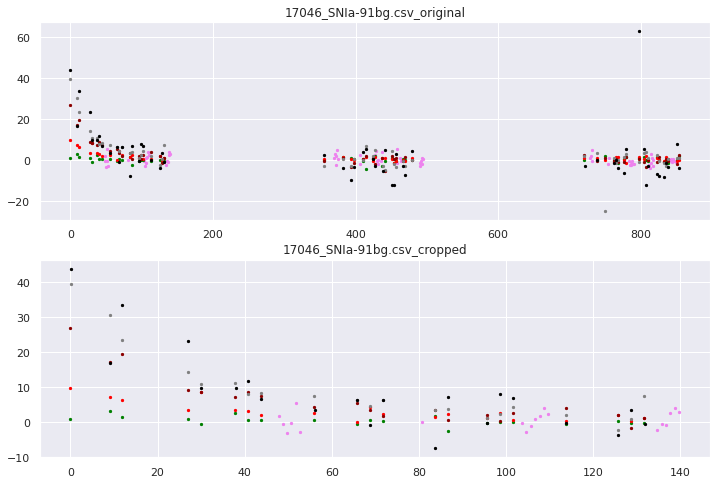

----------------------------------------------------------------------------------------------------


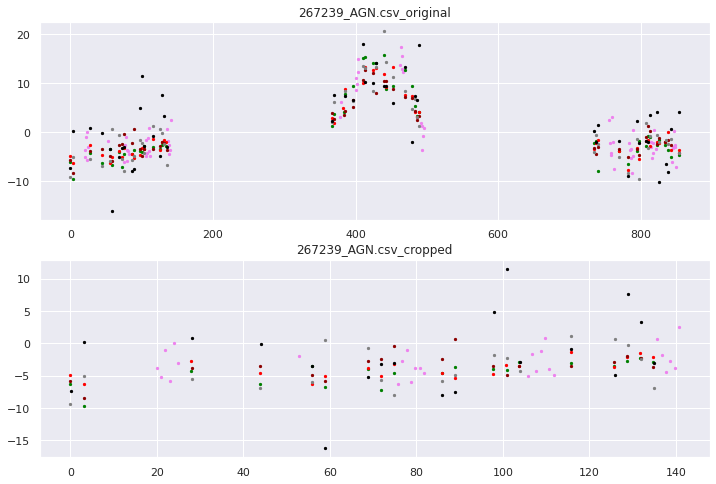

----------------------------------------------------------------------------------------------------


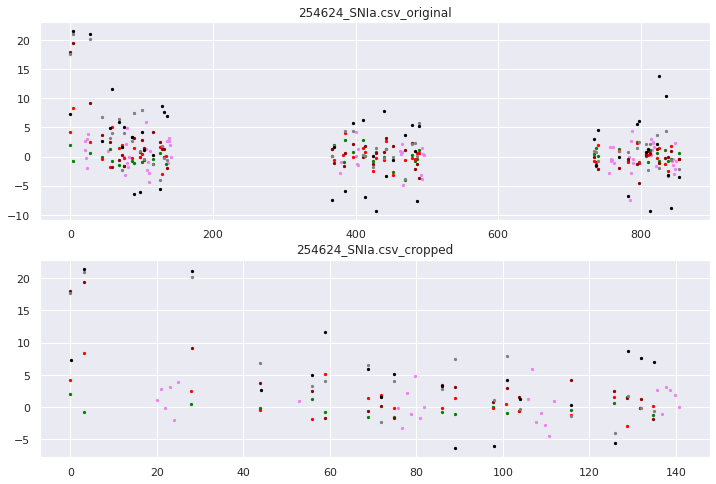

----------------------------------------------------------------------------------------------------


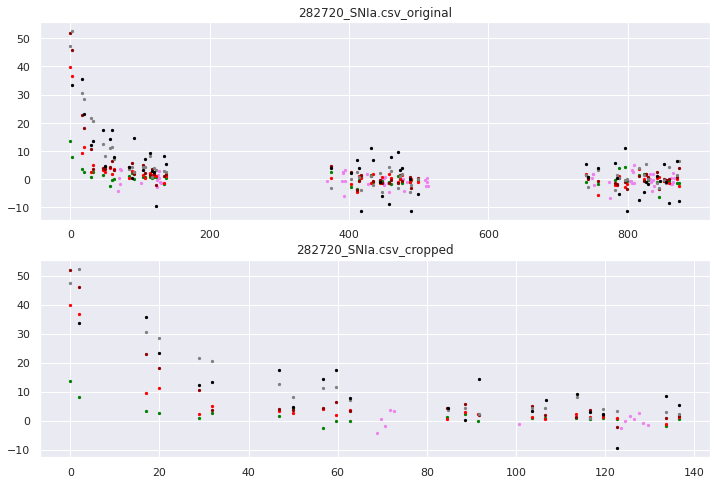

----------------------------------------------------------------------------------------------------


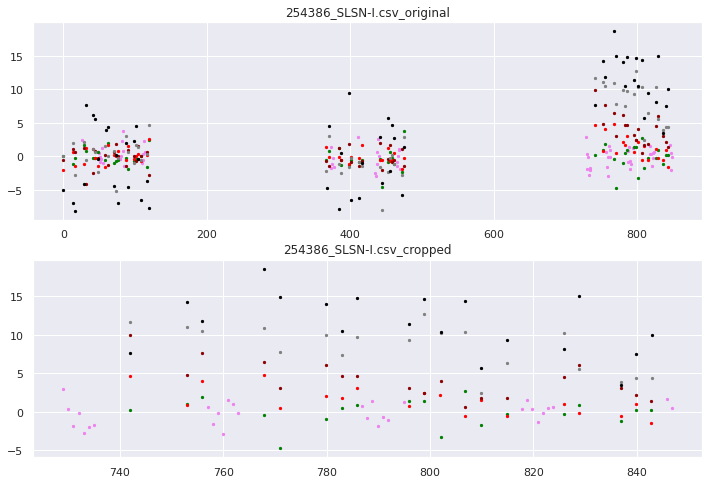

----------------------------------------------------------------------------------------------------


In [7]:
for file in random.sample(filels,10):
    title=file.split("/")[-1]
    df = pd.read_csv(file)
    newdf = center_bigdf(df)
#     print(newdf["mjd"].max() - newdf["mjd"].min())
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(12,8))
    
    plot_allbands_df(df,ax=ax1,title=title+"_original")

    plot_allbands_df(newdf,ax=ax2,title=title+"_cropped")
    plt.show()
    print("-"*100)

In [8]:
if not os.path.isdir("centered_csv_data"):
    os.mkdir("centered_csv_data")

In [9]:
for file in tqdm(filels):
    df = pd.read_csv(file)
    newdf = center_bigdf(df)
    if len(newdf)==0:
        print(file)
    newdf.to_csv(f"centered_csv_data/{file.split('/')[-1]}",index=False)

  0%|          | 0/480 [00:00<?, ?it/s]